# MODELS

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [3]:
df = pd.read_csv('../data/processed/polar_bear_processed_final.csv')
df.head()

,UniqueAnimalID,timestamp,mu_lat,mu_lon,se_mu_x,se_mu_y,adj_lat,adj_lon,date_str,lat2,...,cloud_cover,prev_lat,prev_lon,prev_se_x,prev_se_y,bearing,prev_bearing,bearing_change,date,distance_per_day
0,120,2008-08-30 06:00:00,70.5710,-151.8802,30,30,68.827253,-154.186473,2008-08-30,68.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,2008-08-30,567.382189
1,120,2008-08-30 12:00:00,70.5710,-151.8801,30,30,70.907069,-148.223496,2008-08-30,70.91,...,NaN,68.827253,-154.186473,30.0,30.0,193.599098,NaN,0.000000,2008-08-30,567.382189
2,120,2008-08-30 18:00:00,70.5706,-151.8790,30,30,73.027631,-146.546143,2008-08-30,73.03,...,NaN,70.907069,-148.223496,30.0,30.0,140.935508,193.599098,52.663590,2008-08-30,567.382189
3,120,2008-08-31 00:00:00,70.5714,-151.8821,30,30,71.741506,-159.600333,2008-08-31,71.74,...,NaN,73.027631,-146.546143,30.0,30.0,177.763315,140.935508,36.827807,2008-08-31,1416.241258
4,120,2008-08-31 06:00:00,70.5714,-151.8822,30,30,71.983567,-152.208099,2008-08-31,71.98,...,NaN,71.741506,-159.600333,30.0,30.0,160.095261,177.763315,17.668054,2008-08-31,1416.241258


___________________________________________________________________________

# MODELO DE REGRESIÓN LINEAL


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122014 entries, 0 to 122013
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   UniqueAnimalID     122014 non-null  int64  
 1   timestamp          122014 non-null  object 
 2   mu_lat             122014 non-null  float64
 3   mu_lon             122014 non-null  float64
 4   se_mu_x            122014 non-null  int64  
 5   se_mu_y            122014 non-null  int64  
 6   adj_lat            122014 non-null  float64
 7   adj_lon            122014 non-null  float64
 8   date_str           122014 non-null  object 
 9   lat2               122014 non-null  float64
 10  lon2               122014 non-null  float64
 11  proj_x             122014 non-null  float64
 12  proj_y             122014 non-null  float64
 13  distance_km        122014 non-null  float64
 14  velocity_kmh       122014 non-null  float64
 15  acceleration_kmh2  122014 non-null  float64
 16  da

In [6]:
df.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122014 entries, 0 to 122013
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   timestamp  122014 non-null  object
 1   date_str   122014 non-null  object
 2   date       122014 non-null  object
dtypes: object(3)
memory usage: 2.8+ MB


## 1. ¿Qué distancia medie recorre? _distance_per_day_

In [8]:

df_model = df.copy()

# Format fecha
df_model['date'] = pd.to_datetime(df_model['timestamp']).dt.date
df_model['date_ordinal'] = pd.to_datetime(df_model['date']).map(pd.Timestamp.toordinal)

# Agrupar por animal y fecha
daily_distance = df_model.groupby(['UniqueAnimalID', 'date']).agg({
    'distance_km': 'sum',
    'velocity_kmh': 'mean',
    'acceleration_kmh2': 'mean',
    'daylight_hours': 'mean',
    'cdr_seaice_conc': 'mean',
    'date_ordinal': 'mean'
}).reset_index()

daily_distance.rename(columns={'distance_km': 'distance_per_day'}, inplace=True)



In [77]:
daily_distance.head()

,UniqueAnimalID,distance_per_day,velocity_kmh,acceleration_kmh2,daylight_hours,cdr_seaice_conc,date_ordinal
0,120,567.382189,31.521233,2.247575,-8.023475,0.0,733284.0
1,120,1416.241258,59.010052,1.744582,-7.855865,0.0,733285.0
2,120,2843.899583,118.495816,3.895030,-8.279588,0.0,733286.0
3,120,1796.372546,74.848856,-3.800930,-8.841526,0.0,733287.0
4,120,3112.562989,129.690125,2.739767,-8.160235,0.0,733288.0


#  EDA 


In [14]:
daily_distance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30544 entries, 0 to 30543
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   UniqueAnimalID     30544 non-null  int64  
 1   date               30544 non-null  object 
 2   distance_per_day   30544 non-null  float64
 3   velocity_kmh       30544 non-null  float64
 4   acceleration_kmh2  30544 non-null  float64
 5   daylight_hours     30544 non-null  float64
 6   cdr_seaice_conc    14381 non-null  float64
 7   date_ordinal       30544 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 1.9+ MB


In [41]:
30544 - 14381

16163

In [16]:
daily_distance.describe()

,UniqueAnimalID,distance_per_day,velocity_kmh,acceleration_kmh2,daylight_hours,cdr_seaice_conc,date_ordinal
count,30544.000000,30544.000000,30544.000000,30544.000000,30544.000000,14381.000000,30544.00000
mean,411.816789,31439.154495,1309.789814,0.594541,0.894635,0.512191,734338.19873
std,77.747418,16972.196742,707.192262,45.291653,8.544410,0.483634,1046.50599
min,120.000000,0.000000,0.000000,-466.013231,-21.632971,0.000000,732858.00000
25%,363.000000,21416.060269,893.499268,-25.397360,-5.470696,0.000000,733601.00000
50%,411.000000,35527.983791,1479.721372,0.235233,0.424261,0.490000,734050.00000
75%,470.000000,43749.078107,1822.203156,26.807203,6.203148,0.910000,735137.00000
max,541.000000,75706.323067,3176.161565,350.195053,24.000000,2.530000,736663.00000


In [17]:
daily_distance.distance_per_day.mean()

np.float64(31439.154495446)

In [18]:
daily_distance.drop(columns='date', axis=1, inplace=True)

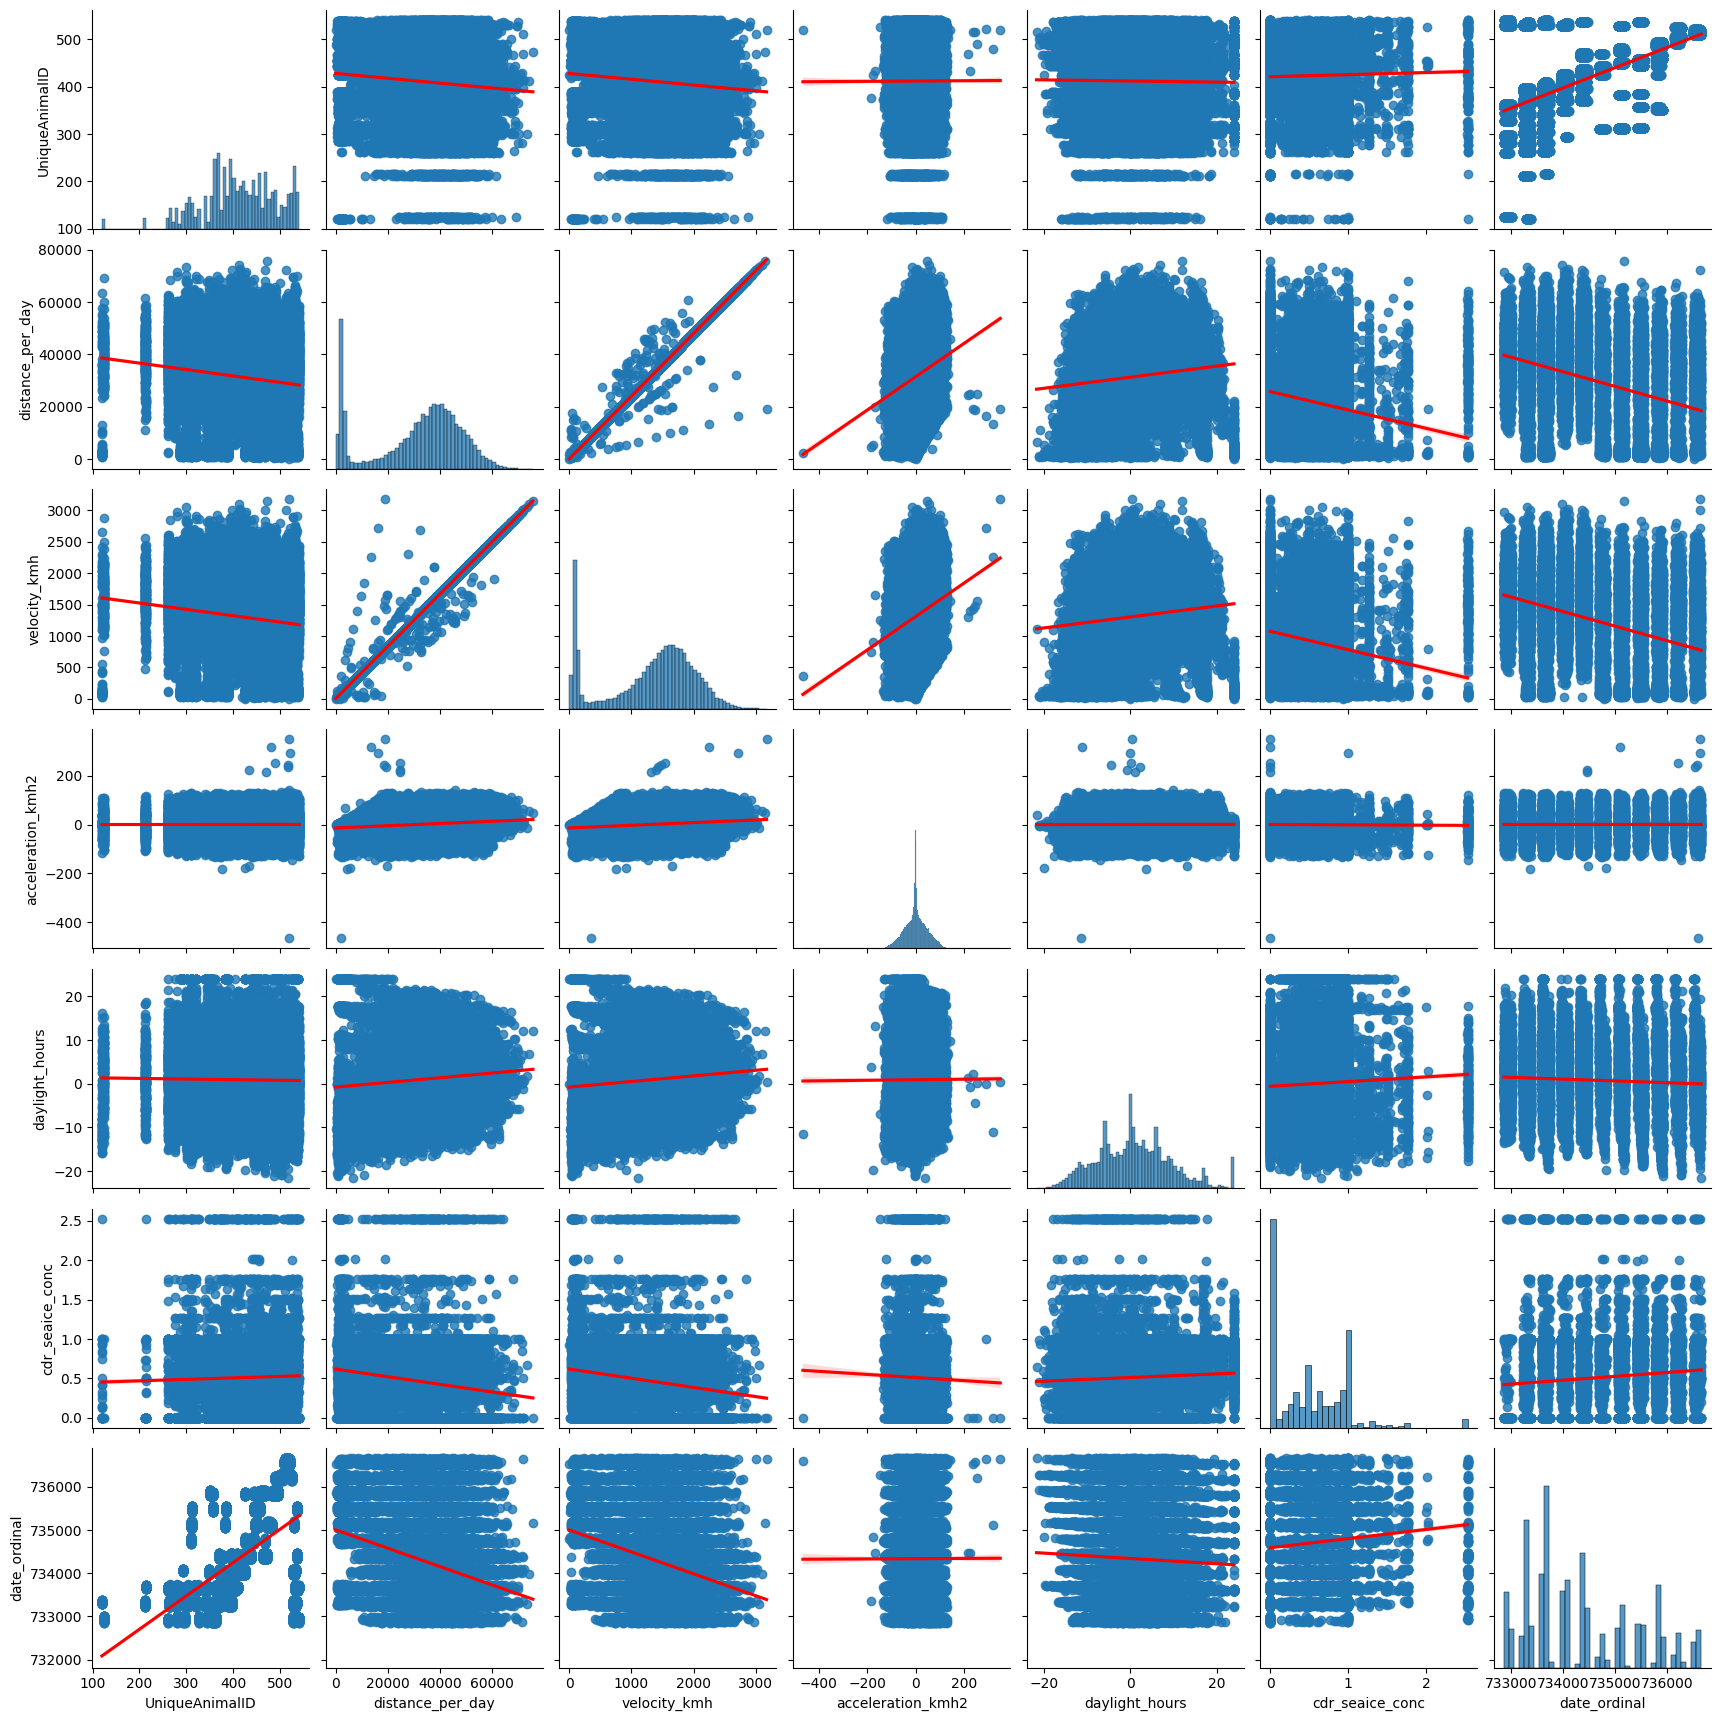

In [27]:
pair_plt = sns.pairplot(daily_distance, kind='reg', diag_kind='hist', plot_kws={"line_kws": {"color": "red"}});


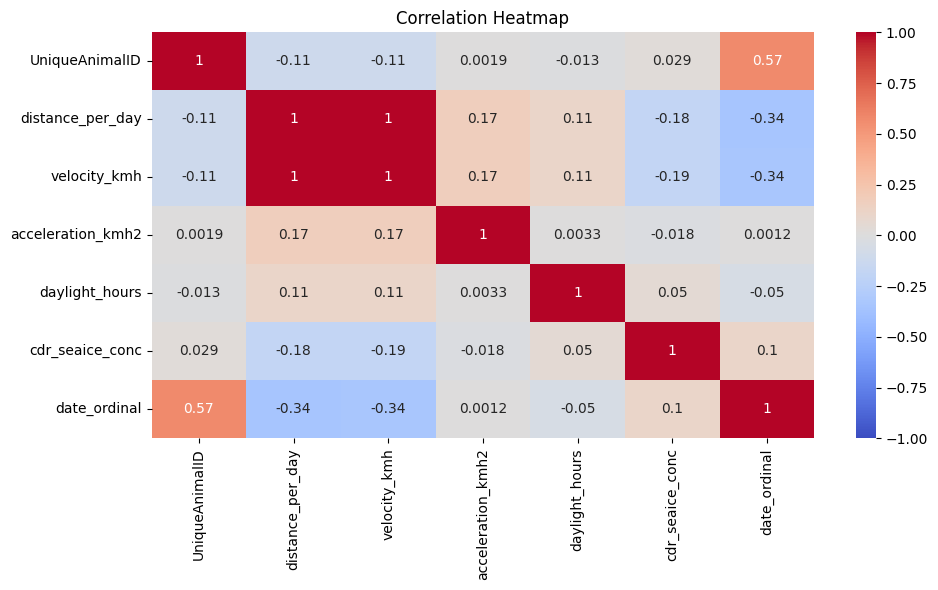

In [19]:
plt.figure(figsize=(10, 6))
sns.heatmap(daily_distance.corr(numeric_only=True), annot=True, cmap="coolwarm", vmin=-1)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show();


Correlaciones:

In [21]:
corr_matrix = daily_distance.corr()
target_corr = corr_matrix['distance_per_day'].drop('distance_per_day')
strong_target_corr = target_corr[abs(target_corr) > 0.3]
strong_target_corr = strong_target_corr.sort_values(ascending=False)
print(strong_target_corr)

velocity_kmh    0.998488
date_ordinal   -0.343890
Name: distance_per_day, dtype: float64


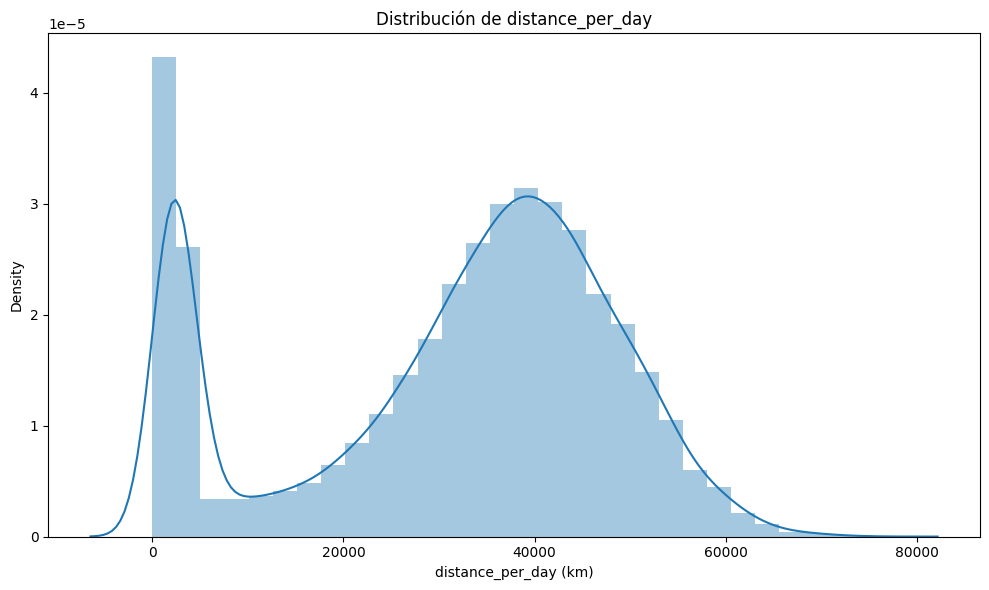

In [25]:
plt.figure(figsize=(10, 6))
sns.distplot(daily_distance['distance_per_day'], kde=True, bins=30)
plt.title("Distribución de distance_per_day")
plt.xlabel("distance_per_day (km)")
plt.tight_layout()
plt.show()


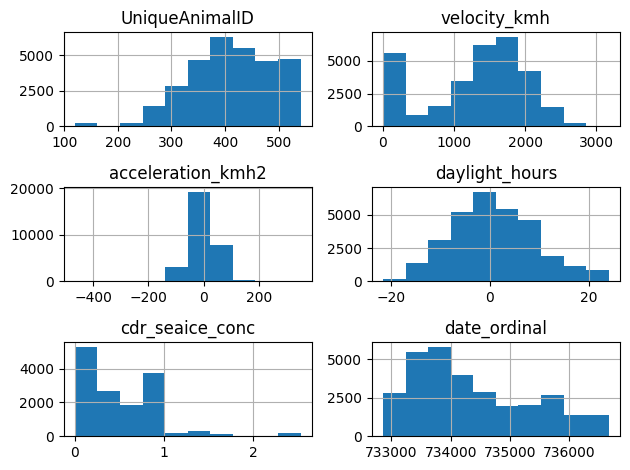

In [29]:
daily_distance.drop(columns='distance_per_day', axis=1).hist()
plt.tight_layout()
plt.show();

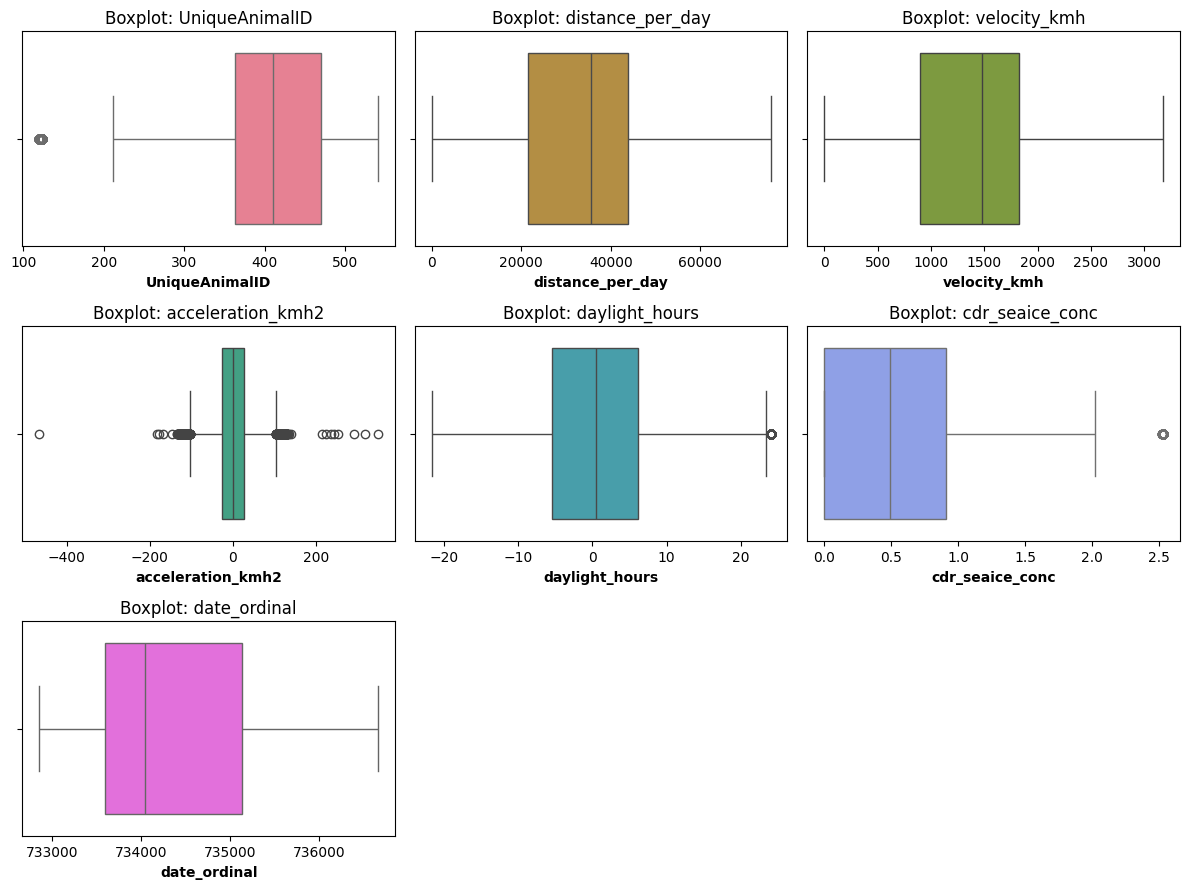

In [40]:
import math

cols = daily_distance.columns.values
colors = sns.color_palette("husl", len(cols)) 

n = len(cols)
ncols = 3  # número de columnas por fila
nrows = math.ceil(n / ncols)

plt.figure(figsize=(ncols * 4, nrows * 3))

for i, col in enumerate(cols):
    plt.subplot(nrows, ncols, i+1)
    sns.boxplot(x=daily_distance[col], color=colors[i])
    plt.xlabel(col, fontsize=10, fontweight='bold')
    plt.title(f'Boxplot: {col}')
    plt.tight_layout()

plt.show()

# Modelado


In [50]:
features = ['date_ordinal', 'velocity_kmh', 'acceleration_kmh2', 'daylight_hours', 'cdr_seaice_conc']
target = ['distance_per_day']
X = daily_distance[features].fillna(0)
y = daily_distance['distance_per_day']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


In [51]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (24435, 5)
X_test: (6109, 5)
y_train: (24435,)
y_test: (6109,)


# Linear Regression

In [46]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Ridge Regression con búsqueda de alpha

In [47]:
alphas = np.logspace(-4, 4, 20)
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, param_grid={'alpha': alphas}, cv=5)
ridge_cv.fit(X_train, y_train)
y_pred_ridge = ridge_cv.predict(X_test)

# Métricas

In [49]:
print("Linear Regression:")
print(f"  MAE: {(mean_absolute_error(y_test, y_pred_lr)):.2f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}")
print(f"  R²:   {r2_score(y_test, y_pred_lr):.3f}")

print("\nRidge Regression:")
print(f"  MAE: {(mean_absolute_error(y_test, y_pred_ridge)):.2f}")
print(f"  Best alpha: {ridge_cv.best_params_['alpha']}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ridge)):.2f}")
print(f"  R²:   {r2_score(y_test, y_pred_ridge):.3f}")


Linear Regression:
  MAE: 111.40
  RMSE: 966.72
  R²:   0.997

Ridge Regression:
  MAE: 110.96
  Best alpha: 545.5594781168514
  RMSE: 966.68
  R²:   0.997


# GridSearchCV

## 1. Linear Regression


In [57]:
lr = make_pipeline(StandardScaler(), LinearRegression())
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
rmse_lr

np.float64(966.7170440642648)

##  2. Ridge Regression con GridSearch 

In [65]:
ridge = Ridge()
ridge_params = {'ridge__alpha': [0.1, 1.0, 10.0, 100.0]}

ridge_grid = GridSearchCV(
    make_pipeline(StandardScaler(), ridge),
    ridge_params,
    scoring='neg_root_mean_squared_error',
    cv=5
)
ridge_grid.fit(X_train, y_train)
best_ridge = ridge_grid.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))



##  3. XGBoost con GridSearch 


In [66]:
xgb = XGBRegressor(random_state=42, verbosity=0)
xgb_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1, 0.2]
}

xgb_grid = GridSearchCV(
    xgb,
    xgb_params,
    scoring='neg_root_mean_squared_error',
    cv=5
)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))



##  Resultados

In [67]:

print("📊 RMSEs:")
print(f"Linear Regression: {rmse_lr:.3f}")
print(f"Ridge (best alpha={ridge_grid.best_params_['ridge__alpha']}): {rmse_ridge:.3f}")
print(f"XGBoost (best params={xgb_grid.best_params_}): {rmse_xgb:.3f}")


📊 RMSEs:
Linear Regression: 966.717
Ridge (best alpha=0.1): 966.717
XGBoost (best params={'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}): 1022.543


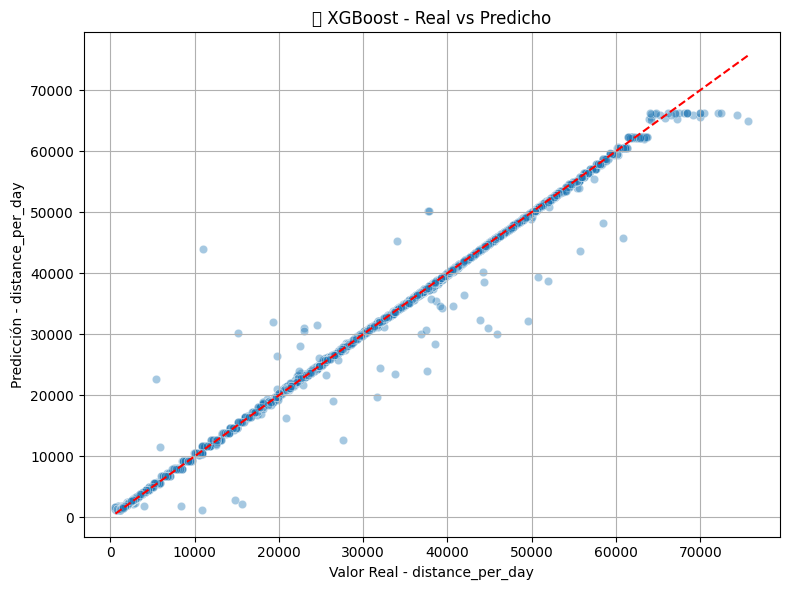

In [68]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valor Real - distance_per_day")
plt.ylabel("Predicción - distance_per_day")
plt.title("📈 XGBoost - Real vs Predicho")
plt.grid(True)
plt.tight_layout()
plt.show()


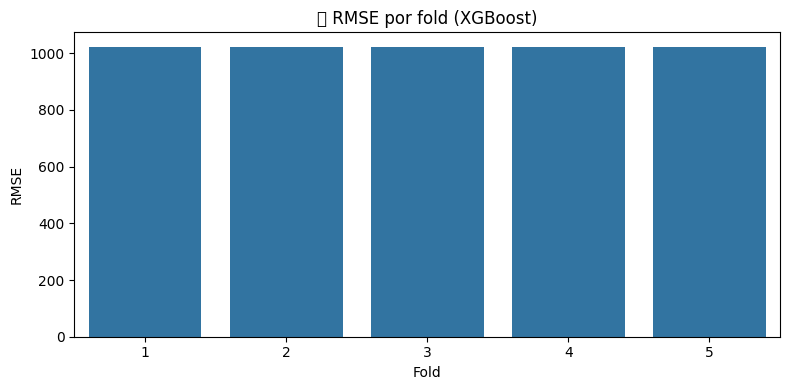

In [ ]:
plt.figure(figsize=(8, 4))
sns.barplot(x=list(range(1, 6)), y=rmse_xgb)
plt.title("RMSE por fold (XGBoost)")
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()


## Cross_validation

In [86]:
def evaluate_model_cv(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    return rmse_scores.mean(), rmse_scores.std()


In [ ]:
# Eval
rmse_lr_mean, rmse_lr_std = evaluate_model_cv(lr, X, y)
rmse_ridge_mean, rmse_ridge_std = evaluate_model_cv(best_ridge, X, y)
rmse_xgb_mean, rmse_xgb_std = evaluate_model_cv(best_xgb, X, y)


In [89]:
cv_results = pd.DataFrame({
    'Modelo': ['LinearRegression', 'Ridge', 'XGBoost'],
    'RMSE medio': [rmse_lr_mean, rmse_ridge_mean, rmse_xgb_mean],
    'RMSE std': [rmse_lr_std, rmse_ridge_std, rmse_xgb_std]
})

# Sort por rendimiento
cv_results = cv_results.sort_values('RMSE medio').reset_index(drop=True)
cv_results


,Modelo,RMSE medio,RMSE std
0,LinearRegression,900.365199,246.679085
1,Ridge,900.365462,246.677778
2,XGBoost,934.935664,194.708313


## FE

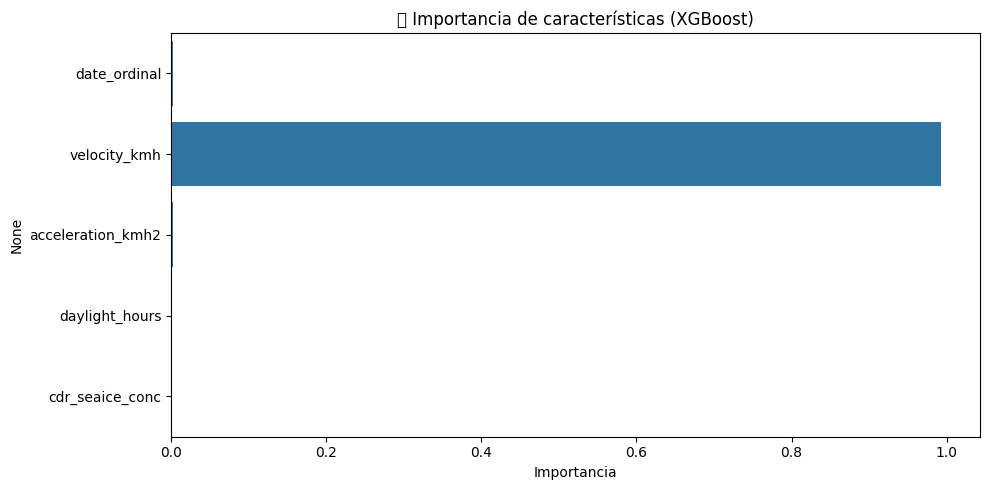

In [88]:
importances = best_xgb.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 5))
sns.barplot(x=importances, y=feature_names)
plt.title("📊 Importancia de características (XGBoost)")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()


In [72]:
feature_importance = best_xgb.feature_importances_
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)

print(importance_df)

             feature  importance
1       velocity_kmh    0.993408
0       date_ordinal    0.002382
2  acceleration_kmh2    0.002208
3     daylight_hours    0.001560
4    cdr_seaice_conc    0.000442


In [81]:
rmse_lr_mean, rmse_lr_std = evaluate_model_cv(lr, X, y)
rmse_ridge_mean, rmse_ridge_std = evaluate_model_cv(best_ridge, X, y)
rmse_xgb_mean, rmse_xgb_std = evaluate_model_cv(best_xgb, X, y)


NameError: name 'cross_val_score' is not defined

## ¿Coordenadas futuras ``lat + 1, lon + 1``?

-LR, Ridge, XGBoost